# Modelos: KNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import util as ut

import random

<Figure size 432x288 with 0 Axes>

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.11.0'

In [8]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

<torch._C.Generator object at 0x7f1953139850>

In [9]:
WEIGHTS_PATH = '../weights'

In [10]:
TRAIN = False

## Carga de dataset

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191540 entries, 0 to 191539
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      191540 non-null  int64         
 1   user_seq                     191540 non-null  int64         
 2   user_movie_tags              191540 non-null  object        
 3   user_movie_rating            191540 non-null  int64         
 4   user_movie_rating_timestamp  191540 non-null  datetime64[ns]
 5   user_movie_rating_year       191540 non-null  int64         
 6   movie_id                     191540 non-null  int64         
 7   movie_seq                    191540 non-null  int64         
 8   movie_title                  191540 non-null  string        
 9   movie_genres                 191540 non-null  object        
 10  movie_for_adults             191540 non-null  bool          
 11  movie_original_language   

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-07-24 13:55:15,849 - INFO - Train: 83.74 % - Test: 7.71 %


## Entrenamiento del modelo

In [13]:
if TRAIN:
    user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

In [14]:
if TRAIN:
    user_predictor.plot()

In [15]:
if TRAIN:
    item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

In [16]:
if TRAIN:
    item_predictor.plot()

Se guardan los modelo entrenado:

In [17]:
if TRAIN:
    user_predictor.save(WEIGHTS_PATH,'knn-user-predictor ')
    item_predictor.save(WEIGHTS_PATH,'knn-item-predictor')

In [18]:
if TRAIN:
    user_predictor.delete()
    item_predictor.delete()

## Validación del modelo

In [19]:
ut.free_gpu_memory()

In [20]:
user_predictor = ml.KNNUserBasedPredictor.from_file(WEIGHTS_PATH, 'knn-user-predictor')

In [21]:
item_predictor = ml.KNNItemBasedPredictor.from_file(WEIGHTS_PATH,'knn-item-predictor')

Decoramos los predictores un con cache para disminuir los tiempo de predicción, ya que no tiene sentido realizar dos veces la misma predicción para estos modelos donde el resultado no es aleatorio:

In [22]:
cached_user_predictor = ml.CachedPredictor(user_predictor)
cached_item_predictor = ml.CachedPredictor(item_predictor)

Armamos un ensample para validar si mejora la performance de ambos modelos:

In [23]:
ensemple_predictor = ml.EnsemplePredictor([cached_user_predictor, cached_item_predictor])

In [24]:
def validation(
    predictors, 
    n_samples    = 100, 
    batch_size   = 1000, 
    n_neighbors  = 100,
    k            = [5, 5],
    user_index   = 0,
    discretizers = [dr.between(4, 5), dr.between(3, 5)],
    summary_path = '../metrics/knn'
):
    metrics    = [mt.RMSE()]

    for k, discretizer in zip(k, discretizers):
        metrics.extend([
            mt.MeanAveragePrecisionAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserFBetaScoreAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserPrecisionAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserRecallAtk(user_index=user_index, k=k, discretizer=discretizer)
        ])

    validator = ml.Validator(
        n_samples,
        batch_size,
        metrics,
        predictors
    )

    summary = validator.validate(eval_set, n_neighbors=n_neighbors)

    summary.save(summary_path)
    summary = ml.ValidatorSummary.load(summary_path)
    summary.plot(bins=12, show_table=True)


Processing:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

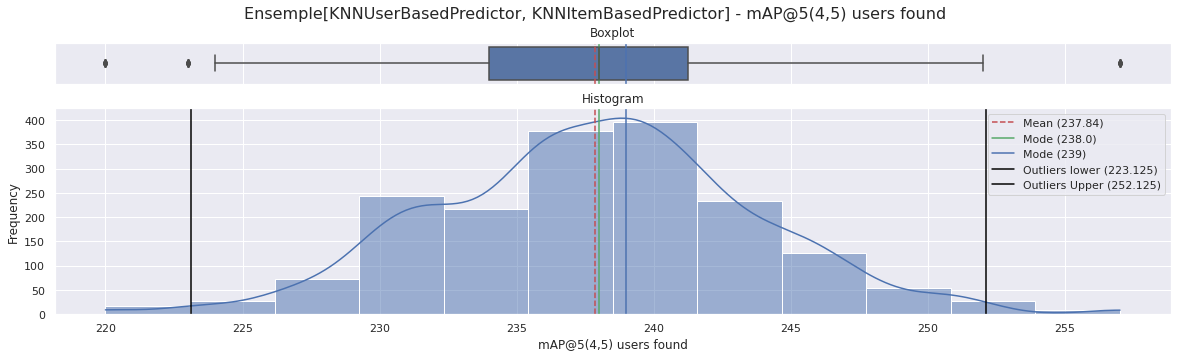

,"mAP@5(4,5) users found"
count,1800.000000
mean,237.840000
std,5.850078
min,220.000000
25%,234.000000
50%,238.000000
75%,241.250000
max,257.000000



Metrics:



<Figure size 1440x360 with 2 Axes>

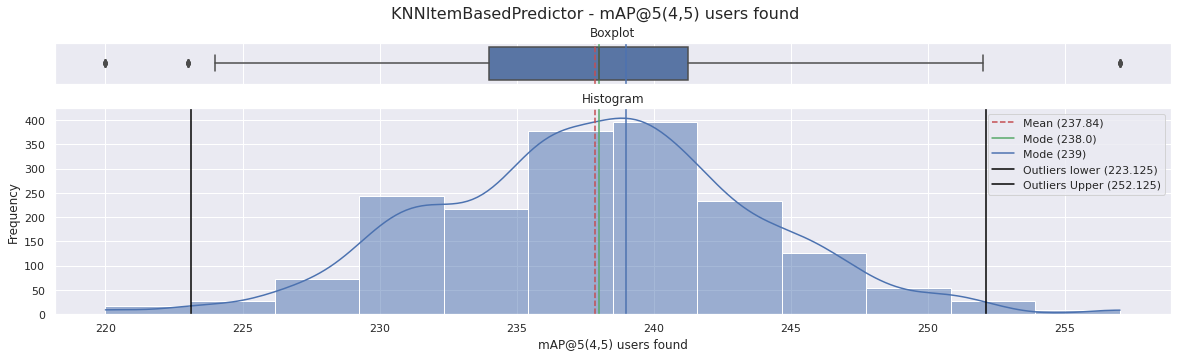


Metrics:



,"mAP@5(4,5) users found"
count,1800.000000
mean,237.840000
std,5.850078
min,220.000000
25%,234.000000
50%,238.000000
75%,241.250000
max,257.000000


<Figure size 1440x360 with 2 Axes>

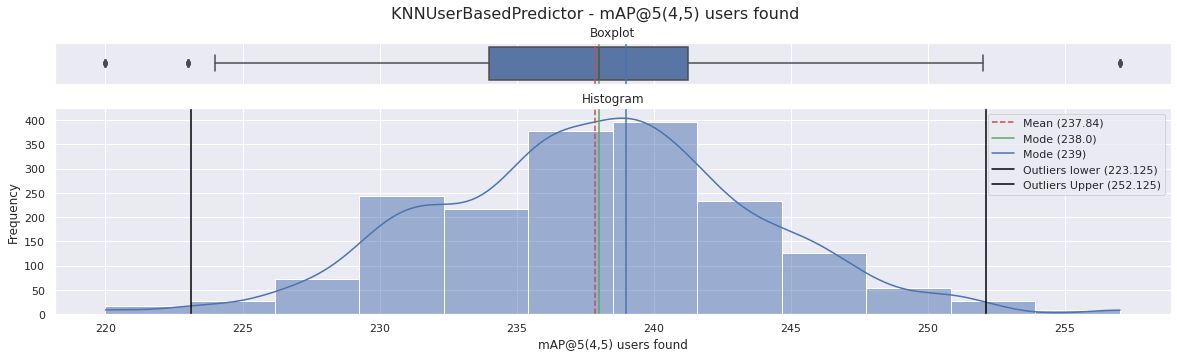


Metrics:



,"mAP@5(4,5) users found"
count,1800.000000
mean,237.840000
std,5.850078
min,220.000000
25%,234.000000
50%,238.000000
75%,241.250000
max,257.000000


<Figure size 1440x360 with 2 Axes>

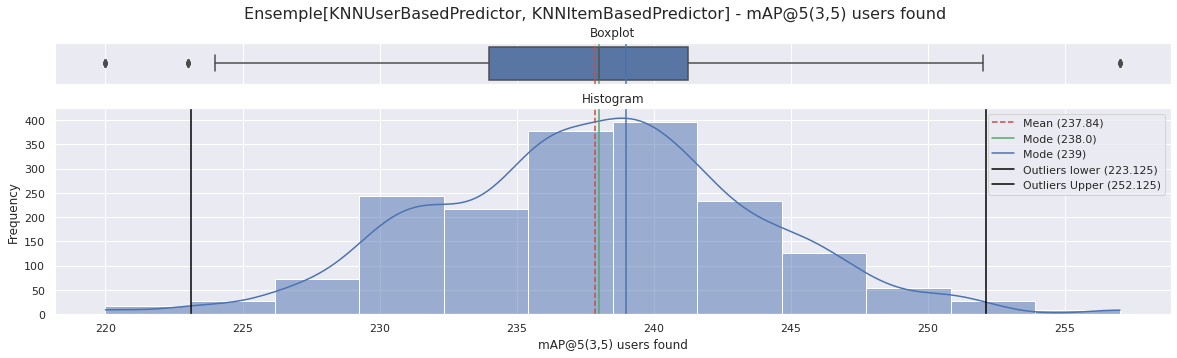


Metrics:



,"mAP@5(3,5) users found"
count,1800.000000
mean,237.840000
std,5.850078
min,220.000000
25%,234.000000
50%,238.000000
75%,241.250000
max,257.000000


<Figure size 1440x360 with 2 Axes>

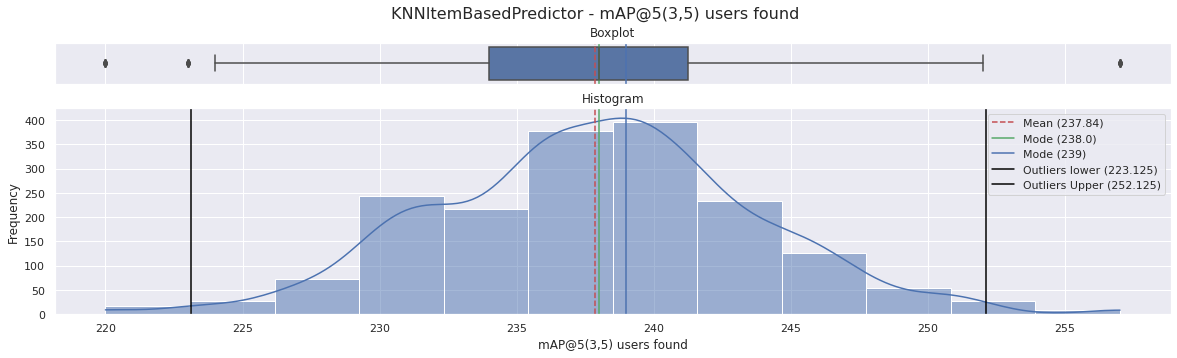


Metrics:



,"mAP@5(3,5) users found"
count,1800.000000
mean,237.840000
std,5.850078
min,220.000000
25%,234.000000
50%,238.000000
75%,241.250000
max,257.000000


<Figure size 1440x360 with 2 Axes>

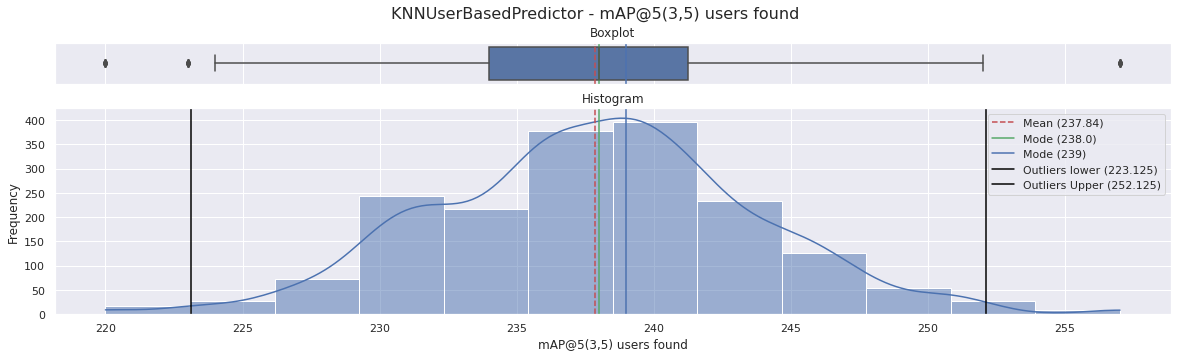


Metrics:



,"mAP@5(3,5) users found"
count,1800.000000
mean,237.840000
std,5.850078
min,220.000000
25%,234.000000
50%,238.000000
75%,241.250000
max,257.000000


<Figure size 1440x360 with 2 Axes>

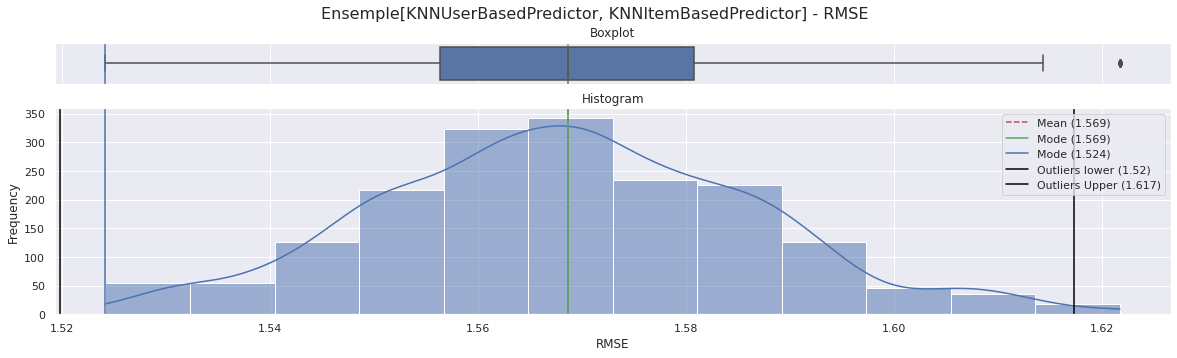


Metrics:



,RMSE
count,1800.000000
mean,1.568607
std,0.018128
min,1.524184
25%,1.556384
50%,1.568606
75%,1.580749
max,1.621711


<Figure size 1440x360 with 2 Axes>

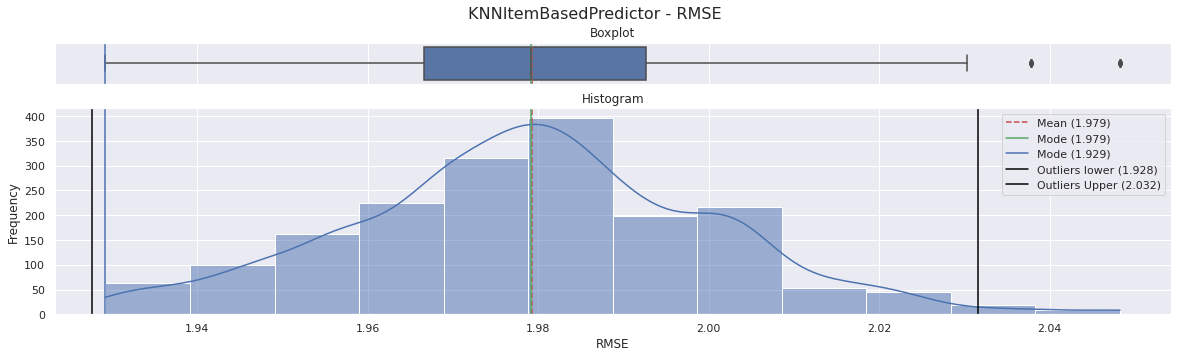


Metrics:



,RMSE
count,1800.000000
mean,1.979244
std,0.021207
min,1.929227
25%,1.966610
50%,1.979183
75%,1.992621
max,2.048249


<Figure size 1440x360 with 2 Axes>

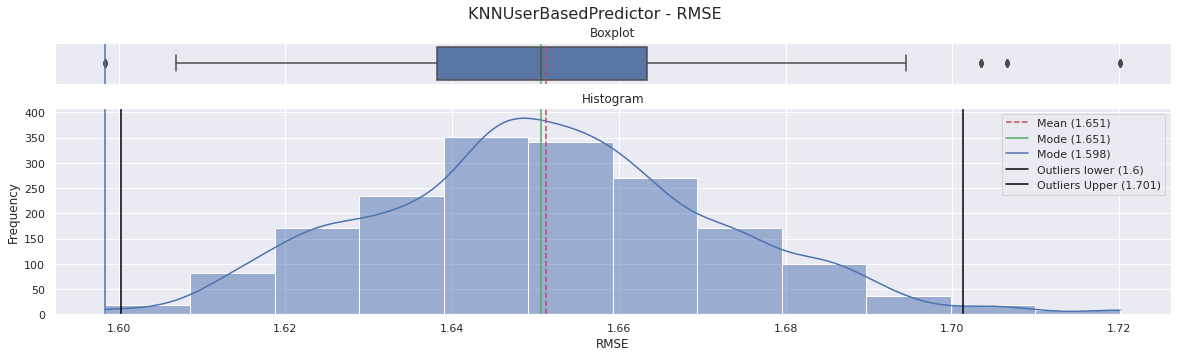


Metrics:



,RMSE
count,1800.000000
mean,1.651205
std,0.020528
min,1.598423
25%,1.638174
50%,1.650711
75%,1.663394
max,1.720104


<Figure size 1440x360 with 2 Axes>

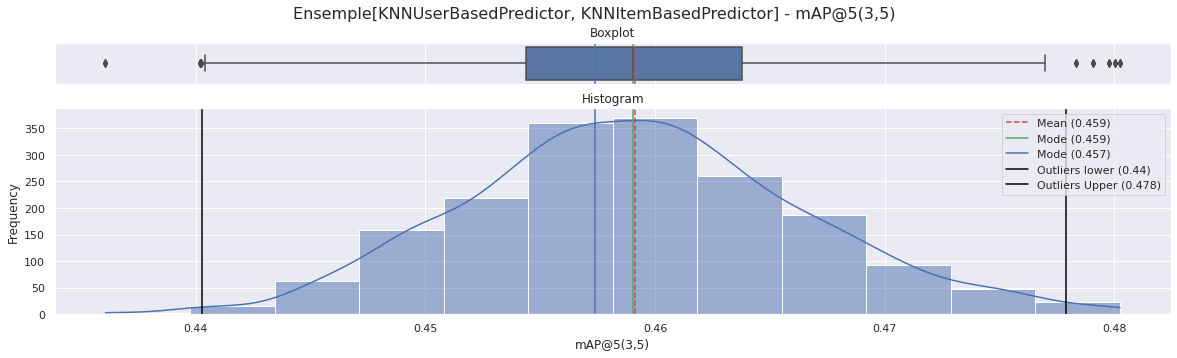


Metrics:



,"mAP@5(3,5)"
count,1800.000000
mean,0.459136
std,0.007361
min,0.436065
25%,0.454382
50%,0.459021
75%,0.463797
max,0.480251


<Figure size 1440x360 with 2 Axes>

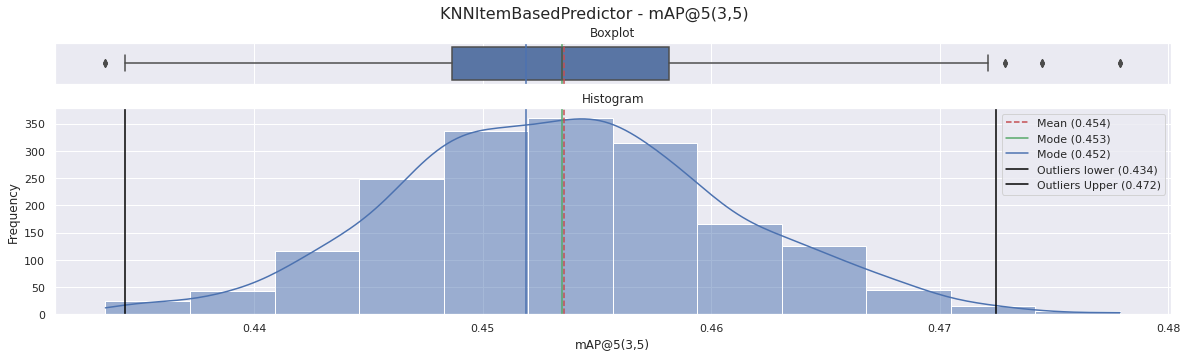


Metrics:



,"mAP@5(3,5)"
count,1800.000000
mean,0.453557
std,0.007258
min,0.433476
25%,0.448629
50%,0.453443
75%,0.458160
max,0.477887


<Figure size 1440x360 with 2 Axes>

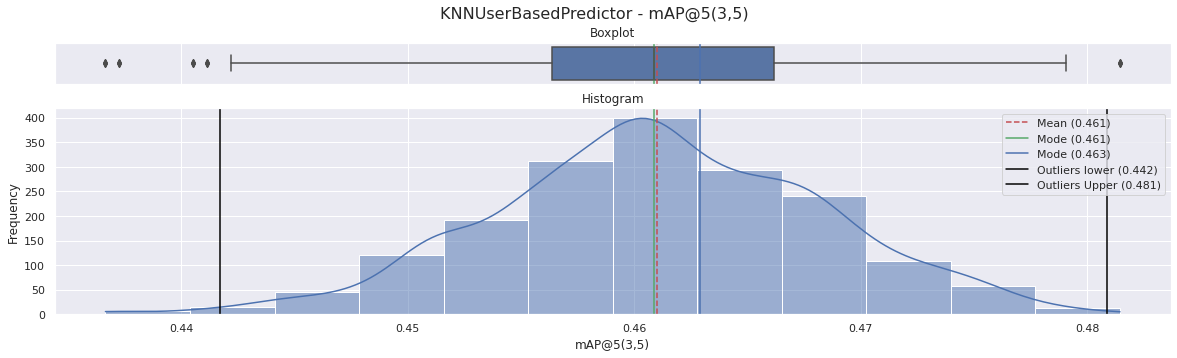


Metrics:



,"mAP@5(3,5)"
count,1800.000000
mean,0.461029
std,0.007265
min,0.436658
25%,0.456385
50%,0.460895
75%,0.466178
max,0.481445


<Figure size 1440x360 with 2 Axes>

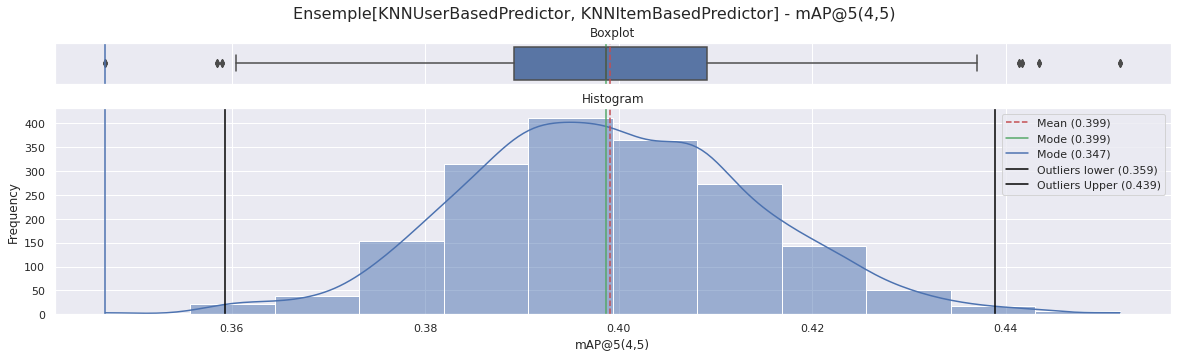


Metrics:



,"mAP@5(4,5)"
count,1800.000000
mean,0.399059
std,0.015099
min,0.346968
25%,0.389184
50%,0.398670
75%,0.409076
max,0.451792


<Figure size 1440x360 with 2 Axes>

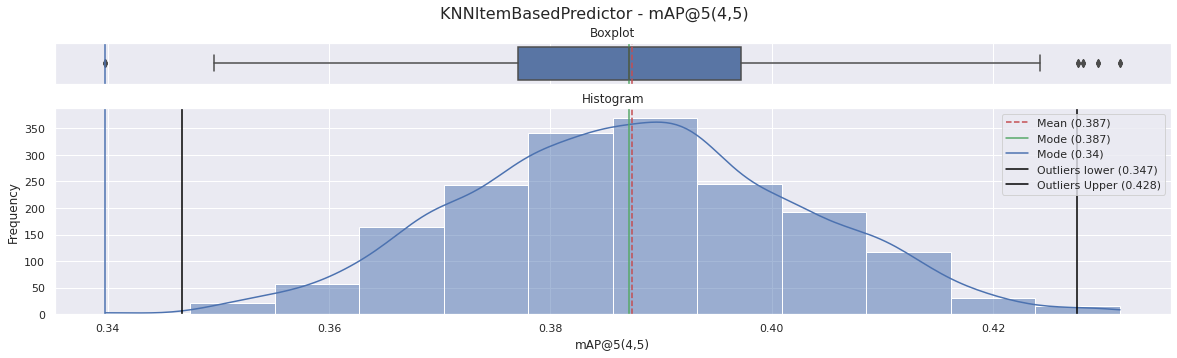


Metrics:



,"mAP@5(4,5)"
count,1800.000000
mean,0.387406
std,0.015015
min,0.339806
25%,0.377050
50%,0.387136
75%,0.397250
max,0.431457


<Figure size 1440x360 with 2 Axes>

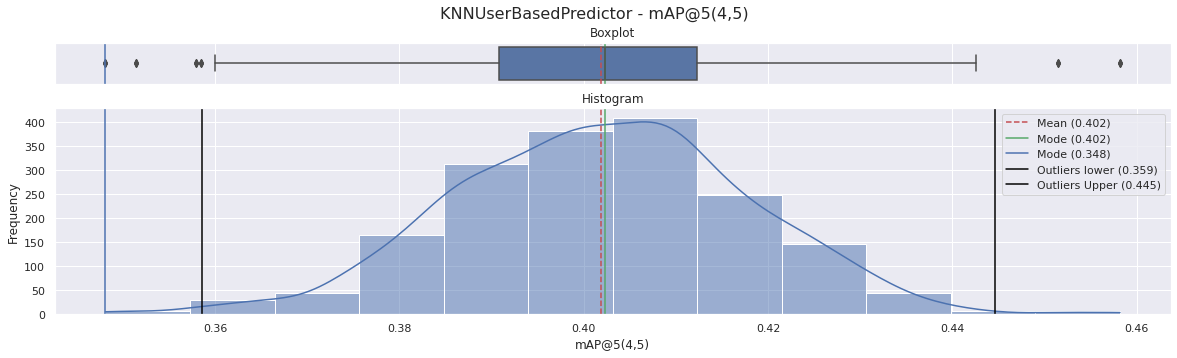


Metrics:



,"mAP@5(4,5)"
count,1800.000000
mean,0.401917
std,0.015998
min,0.348113
25%,0.390817
50%,0.402266
75%,0.412332
max,0.458187


In [29]:
validation(
    [cached_user_predictor, cached_item_predictor, ensemple_predictor],
    n_samples    = 200,
    batch_size   = 5000,
    n_neighbors  = 5000,
    summary_path = '../metrics/knn'
)